In [5]:
import numpy as np
import scipy
import time

import utils_2
from imshows_2 import imshow1, imshow2, imshow3

fnum = 69
wavelength = 908e-9
pixel_size = 13e-6
psf_pixelscale_lamD = 1/ (fnum * wavelength / pixel_size)

Nact = 34
npsf = 256
iwa = 2
owa = 11



In [ ]:
client = indi.client.IndiClient()
client.connect()
time.sleep(0.5)

In [ ]:
dm_channel = XDeformableMirror(dm='dmncpc', channel=7)
cam = XCam('camsci1')

In [ ]:
def set_dm():
    iugab

def add_dm():

    hiavsk

def get_dm():
    kjsba

def snap():
    jhdav

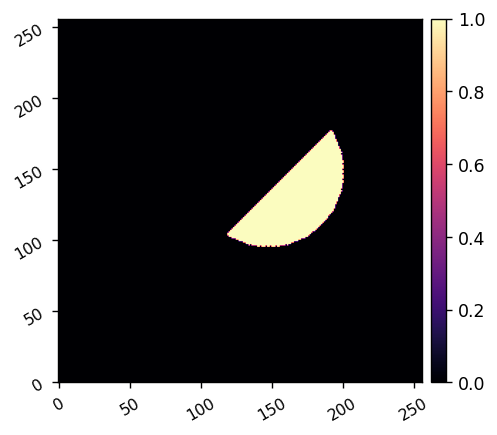

952


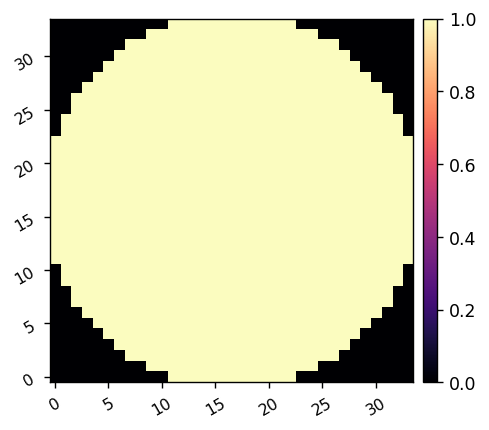

In [12]:
# Creating focal plane masks
def create_annular_focal_plane_mask(psf_pixelscale_lamD, npsf, 
                                    inner_radius, outer_radius, 
                                    edge=None,
                                    shift=(0,0), 
                                    rotation=0,
                                    plot=False):
    x = (np.linspace(-npsf/2, npsf/2-1, npsf) + 1/2)*psf_pixelscale_lamD
    x,y = np.meshgrid(x,x)
    r = np.hypot(x, y)
    mask = (r < outer_radius) * (r > inner_radius)
    if edge is not None: mask *= (x > edge)
    
    mask = scipy.ndimage.rotate(mask, rotation, reshape=False, order=0)
    mask = scipy.ndimage.shift(mask, (shift[1], shift[0]), order=0)
    
    if plot:
        imshow1(mask)
        
    return mask

control_mask_shift = np.array([20,20])
control_mask = create_annular_focal_plane_mask(psf_pixelscale_lamD, npsf, iwa, owa, iwa, 
                                               shift=control_mask_shift, rotation=45, plot=True)

Nact = 34
dm_mask = np.ones((Nact,Nact), dtype=bool)
xx = (np.linspace(-Nact/2, Nact/2-1, Nact)+ 1/2)
x,y = np.meshgrid(xx,xx)
r = np.sqrt(x**2 + y**2)
dm_mask[r>Nact/2+1/2] = 0
print(dm_mask.sum())
imshow1(dm_mask)

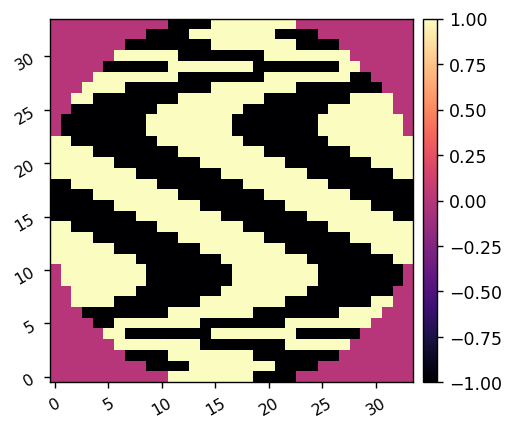

In [13]:
def create_hadamard_modes(dm_mask): 
    Nacts = dm_mask.sum().astype(int)
    np2 = 2**int(np.ceil(np.log2(Nacts)))
    hmodes = scipy.linalg.hadamard(np2)
    
    had_modes = []

    inds = np.where(dm_mask.flatten().astype(int))
    for hmode in hmodes:
        hmode = hmode[:Nacts]
        mode = np.zeros((dm_mask.shape[0]**2))
        mode[inds] = hmode
        had_modes.append(mode)
    had_modes = np.array(had_modes)
    
    return had_modes

had_modes = create_hadamard_modes(dm_mask)
imshow1(had_modes[8].reshape(Nact,Nact))


/tmp/ipykernel_2439372/1202604490.py:6: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://gist.github.com/ev-br/8544371b40f414b7eaf3fe6217209bff`

  intp = scipy.interpolate.interp2d(xfp, xfp, control_mask) # setup the interpolation function
/tmp/ipykernel_2439372/1202604490.py:16: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2

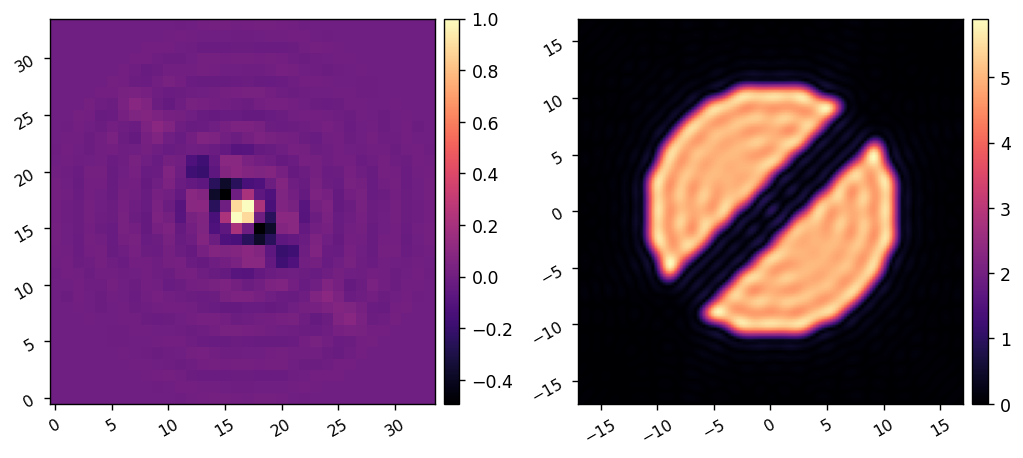

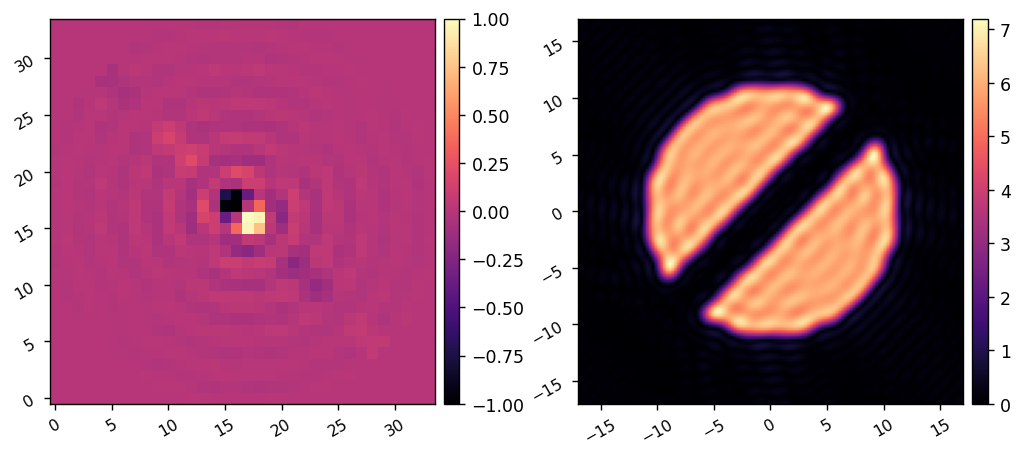

In [15]:
def create_fourier_modes(control_mask,
                         fourier_sampling=0.75, use='both', return_fs=False):
    xfp = (np.linspace(-npsf/2, npsf/2-1, npsf) + 1/2) * psf_pixelscale_lamD
    fpx, fpy = np.meshgrid(xfp,xfp)
    
    intp = scipy.interpolate.interp2d(xfp, xfp, control_mask) # setup the interpolation function
    
    xpp = np.linspace(-Nact/2, Nact/2-1, Nact) + 1/2
    ppx, ppy = np.meshgrid(xpp,xpp)
    
    fourier_lim = fourier_sampling * int(np.round(xfp.max()/fourier_sampling))
    xfourier = np.arange(-fourier_lim-fourier_sampling/2, fourier_lim+fourier_sampling, fourier_sampling)
    fourier_x, fourier_y = np.meshgrid(xfourier, xfourier) 
    
    # Select the x,y frequencies for the Fourier modes to calibrate the dark hole region
    fourier_grid_mask = ( (intp(xfourier, xfourier) * (((fourier_x!=0) + (fourier_y!=0)) > 0)) > 0 )
    
    fxs = fourier_x.ravel()[fourier_grid_mask.ravel()]
    fys = fourier_y.ravel()[fourier_grid_mask.ravel()]
    sampled_fs = np.vstack((fxs, fys)).T
    
    cos_modes = []
    sin_modes = []
    for f in sampled_fs:
        fx = f[0]/Nact
        fy = f[1]/Nact
        cos_modes.append( ( np.cos(2 * np.pi * (fx * ppx + fy * ppy)) * dm_mask ).flatten() ) 
        sin_modes.append( ( np.sin(2 * np.pi * (fx * ppx + fy * ppy)) * dm_mask ).flatten() )
    if use=='both' or use=='b':
        modes = cos_modes + sin_modes
    elif use=='cos' or use=='c':
        modes = cos_modes
    elif use=='sin' or use=='s':
        modes = sin_modes
    
    if return_fs:
        return np.array(modes), sampled_fs
    else:
        return np.array(modes)

def fourier_mode(lambdaD_yx, rms=1, acts_per_D_yx=(34,34), Nact=34, phase=0):
    idy, idx = np.indices((Nact, Nact)) - (34-1)/2.
    prefactor = rms * np.sqrt(2)
    arg = 2*np.pi*(lambdaD_yx[0]/acts_per_D_yx[0]*idy + lambdaD_yx[1]/acts_per_D_yx[1]*idx)
    return prefactor * np.cos(arg + phase)

def create_fourier_probes(control_mask,
                          fourier_sampling=0.25, 
                          shift=(0,0), 
                          nprobes=2, 
                          plot=False, 
                          calc_responses=False): 
#     make probe modes from the sum of the cos and sin fourier modes
    fourier_modes = create_fourier_modes(control_mask, fourier_sampling=fourier_sampling, use='both')
    nfs = fourier_modes.shape[0]//2
    
    probes = np.zeros((nprobes, Nact, Nact))
    sum_cos = fourier_modes[:nfs].sum(axis=0).reshape(Nact,Nact)
    sum_sin = fourier_modes[nfs:].sum(axis=0).reshape(Nact,Nact)
    
    # nprobes=2 will give one probe that is purely the sum of cos and another that is the sum of sin
    cos_weights = np.linspace(1,0,nprobes)
    sin_weights = np.linspace(0,1,nprobes)
    
    if not isinstance(shift, list):
        shifts = [shift]*nprobes
    else:
        shifts = shift
    for i in range(nprobes):
        probe = cos_weights[i]*sum_cos + sin_weights[i]*sum_sin
        probe = scipy.ndimage.shift(probe, (shifts[i][1], shifts[i][0]))
        probes[i] = probe/np.max(probe)
        
        if plot: 
            response = np.abs(np.fft.ifftshift(np.fft.fft2(np.fft.fftshift( pad_or_crop(probes[i], 4*Nact) ))))
            imshow2(probes[i], response, pxscl2=1/4)
            
    return probes


probe_commands = create_fourier_probes(scipy.ndimage.shift(control_mask, -control_mask_shift), plot=True)

In [ ]:
def take_measurement(probe_cube, probe_amplitude, return_all=False, plot=False):
    differential_operator = []
    for i in range(len(probe_cube)):
        vec = [0]*2*len(probe_cube)
        vec[2*i] = -1
        vec[2*i+1] = 1
        differential_operator.append(vec)
    differential_operator = np.array(differential_operator) / (2 * probe_amplitude)
    
    images = []
    for probe in probe_cube: 
        for s in [-1, 1]:
            add_dm(s*probe_amplitude*probe)
            image = snap()
            images.append(image.flatten())
            add_dm(-s*probe_amplitude*probe)
    images = xp.array(images)
    
    differential_images = differential_operator.dot(images)
    
    if plot:
        for i, diff_im in enumerate(differential_images):
            imshow2(probe_cube[i], diff_im.reshape(npsf, npsf), 
                    f'Probe Command {i+1}', 'Difference Image', pxscl2=psf_pixelscale_lamD,
                    cmap1='viridis')
            
    if return_all:
        return differential_images, images
    else:
        return differential_images

In [ ]:
diff_ims = take_measurement(probes, probe_amp, plot=True)

In [ ]:
def calibrate(control_mask, 
              probe_amplitude, probe_modes,
              calibration_amplitude, calibration_modes, 
              start_mode=0,
              return_all=False, 
              plot=False):

    print('Calibrating iEFC...')
    Nmodes = calibration_modes.shape[0]
    
    response_matrix = []
    if return_all:
        response_cube = []

    # Loop through all modes that you want to control
    start = time.time()
    for i, calibration_mode in enumerate(calibration_modes):
        response = 0
        for s in [-1, 1]:
            # Set the DM to the correct state
            add_dm(s * calibration_amplitude * calibration_mode.reshape(Nact, Nact))
            difference_images = take_measurement(sysi, probe_modes, probe_amplitude, return_all=False)
            response += s * difference_images / (2 * calibration_amplitude)
            add_dm(-s * calibration_amplitude * calibration_mode.reshape(Nact, Nact))

        print(f'\tCalibrated mode {ci+1+start_mode} / {Nmodes} in {time.time()-start:.2f}s', end='')
        print('\r', end='')
        
        measured_response = []
        for i in range(probe_modes.shape[0]):
            measured_response.append(response[i, control_mask.ravel()])
        measured_response = np.array(measured_response)
        response_matrix.append(np.concatenate(measured_response)) # masked response for each probe mode 

    print()
    print('Calibration complete.')
    
    response_matrix = np.array(response_matrix).T
            
    return response_matrix

In [ ]:
def run(control_matrix, 
        probe_modes, probe_amplitude,
        calibration_modes, 
        control_mask,
        num_iterations=10, 
        loop_gain=0.5, 
        leakage=0.0,
        plot_current=True,
        plot_all=False,
        plot_radial_contrast=False,
        old_images=None,
        old_dm_commands=None,):

    print('Running iEFC...')
    start = time.time()
    
    # The metric
    metric_images = []
    dm_commands = []

    dm_ref = sysi.get_dm()
    command = 0.0
    dm_command = 0.0
    if old_images is None:
        starting_iteration = 0
    else:
        starting_iteration = len(old_images) - 1

    for i in range(num_iterations):
        print(f"\tClosed-loop iteration {i+1+starting_iteration} / {num_iterations+starting_iteration}")

        differential_images = take_measurement(probe_modes, probe_amplitude)
        measurement_vector = differential_images[:, control_mask.ravel()].ravel()

        modal_coefficients = -control_matrix.dot( measurement_vector )
        command = (1.0-leakage)*command + loop_gain*modal_coefficients
        
        act_commands = calibration_modes.T.dot(command)
        dm_command = act_commands.reshape(Nact,Nact)
        
        # Set the current DM state
        set_dm(dm_ref + dm_command)
        
        # Take an image to estimate the metrics
        image = snap()
        mean_ni = np.mean(image[control_mask])
        
        metric_images.append(image)
        dm_commands.append(get_dm())

        if plot_current: 
            if not plot_all: clear_output(wait=True)
            vmin = np.min(metric_images[i]) if xp.min(metric_images[i])>1e-11 else 1e-11
            imshow2(dm_commands[i], metric_images[i], 
                               'DM', f'Image: Iteration {i+starting_iteration+1}\nMean NI: {mean_ni:.3e}',
                            cmap1='viridis',
                               lognorm2=True, vmin2=vmin, pxscl2=psf_pixelscale_lamD)
                
    metric_images = np.array(metric_images)
    dm_commands = np.array(dm_commands)
    
    if old_images is not None:
        metric_images = np.concatenate([old_images, metric_images], axis=0)
    if old_dm_commands is not None: 
        dm_commands = np.concatenate([old_dm_commands, dm_commands], axis=0)
        
    return metric_images, dm_commands